##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Keras の再帰型ニューラルネットワーク（RNN）

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/guide/keras/rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で実行</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/keras/rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">	Google Colabで実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/keras/rnn.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/keras/rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">	ノートブックをダウンロード</a> </td>
</table>

## はじめに

再帰型ニューラルネットワーク（RNN）は、時系列や自然言語などのシーケンスデータのモデリングを強力に行うニューラルネットワークのクラスです。

概略的には、RNN レイヤーは `for` ループを使用して、それまでに確認した時間ステップに関する情報をエンコードする内部状態を維持しながらシーケンスの時間ステップをイテレートします。

Keras RNN API は、次に焦点を当てて設計されています。

- **使いやすさ**: `keras.layers.RNN`、`keras.layers.LSTM`、`keras.layers.GRU` レイヤーがビルトインされているため、難しい構成選択を行わずに、再帰型モデルを素早く構築できます。

- **カスタマイズしやすさ**: カスタムビヘイビアを使って独自の RNN セルレイヤーを構築し（`for` ループの内部）、一般的な `keras.layers.RNN` レイヤー（`for` ループ自体）で使用することもできます。このため、異なるリサーチアイデアを最小限のコードで柔軟に素早くプロトタイプすることができます。

## セットアップ

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-12-14 21:38:01.496796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:38:01.496895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:38:01.496905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## ビルトイン RNN レイヤー: 単純な例

Keras には、次の 3 つのビルトイン RNN レイヤーがあります。

1. `keras.layers.SimpleRNN`: 前の時間ステップの出力が次の時間ステップにフィードされる、完全に連結された RNN です。

2. `keras.layers.GRU`: [Cho et al., 2014](https://arxiv.org/abs/1406.1078) で初めて提案されたレイヤー。

3. `keras.layers.LSTM`: [Hochreiter &amp; Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf) で初めて提案されたレイヤー。

2015 年始めに、Keras に、LSTM および GRU の再利用可能なオープンソース Python 実装が導入されました。

整数のシーケンスを処理し、そのような整数を 64 次元ベクトルに埋め込み、`LSTM` レイヤーを使用してベクトルのシーケンスを処理する `Sequential` モデルの単純な例を次に示しています。

In [3]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, None, 64)          64000     


 lstm (LSTM)                 (None, 128)               98816     


 dense (Dense)               (None, 10)                1290      


Total params: 164,106


Trainable params: 164,106


Non-trainable params: 0


_________________________________________________________________


ビルトイン RNN は、多数の有益な特徴をサポートしています。

- `dropout` および `recurrent_dropout` 引数を介した再帰ドロップアウト
- `go_backwards` 引数を介して、入力シーケンスを逆順に処理する能力
- `unroll` 引数を介したループ展開（CPU で短いシーケンスを処理する際に大幅な高速化が得られる）
- など。

詳細については、「[RNN API ドキュメント](https://keras.io/api/layers/recurrent_layers/)」を参照してください。

## 出力と状態

デフォルトでは、RNN レイヤーの出力には、サンプル当たり 1 つのベクトルが含まれます。このベクトルは、最後の時間ステップに対応する RNN セル出力で、入力シーケンス全体の情報が含まれます。この出力の形状は `(batch_size, units)` で、`units` はレイヤーのコンストラクタに渡される `units` 引数に対応します。

RNN レイヤーは、`return_sequences=True` に設定した場合、各サンプルに対する出力のシーケンス全体（各サンプルの時間ステップごとに 1 ベクトル）を返すこともできます。この出力の形状は `(batch_size, timesteps, units)` です。

In [4]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, None, 64)          64000     


 gru (GRU)                   (None, None, 256)         247296    


 simple_rnn (SimpleRNN)      (None, 128)               49280     


 dense_1 (Dense)             (None, 10)                1290      


Total params: 361,866


Trainable params: 361,866


Non-trainable params: 0


_________________________________________________________________


さらに、RNN レイヤーはその最終内部状態を返すことができます。返された状態は、後で RNN 実行を再開する際に使用するか、[別の RNN を初期化するため](https://arxiv.org/abs/1409.3215)に使用できます。この設定は通常、エンコーダ・デコーダ方式の Sequence-to-Sequence モデルで使用され、エンコーダの最終状態がデコーダの初期状態として使用されます。

内部状態を返すように RNN レイヤーを構成するには、レイヤーを作成する際に、`return_state` パラメータを `True` に設定します。`LSTM` には状態テンソルが 2 つあるのに対し、`GRU` には 1 つしかないことに注意してください。

レイヤーの初期状態を構成するには、追加のキーワード引数 `initial_state` を使ってレイヤーを呼び出します。次の例に示すように、状態の形状は、レイヤーのユニットサイズに一致する必要があることに注意してください。

In [5]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, None)]       0           []                               


 input_2 (InputLayer)           [(None, None)]       0           []                               


 embedding_2 (Embedding)        (None, None, 64)     64000       ['input_1[0][0]']                


 embedding_3 (Embedding)        (None, None, 64)     128000      ['input_2[0][0]']                


 encoder (LSTM)                 [(None, 64),         33024       ['embedding_2[0][0]']            


                                 (None, 64),                                                      


                                 (None, 64)]                                                      


 decoder (LSTM)                 (None, 64)           33024       ['embedding_3[0][0]',            


                                                                  'encoder[0][1]',                


                                                                  'encoder[0][2]']                


 dense_2 (Dense)                (None, 10)           650         ['decoder[0][0]']                


Total params: 258,698


Trainable params: 258,698


Non-trainable params: 0


__________________________________________________________________________________________________


## RNN レイヤーと RNN セル

ビルトイン RNN レイヤーのほかに、RNN API は、セルレベルの API も提供しています。入力シーケンスの全バッチを処理する RNN レイヤーとは異なり、RNN セルは単一の時間ステップのみを処理します。

セルは、RNN レイヤーの `for` ループ内にあります。`keras.layers.RNN` レイヤー内のセルをラップすることで、シーケンスのバッチを処理できるレイヤー（`RNN(LSTMCell(10))` など）を得られます。

数学的には、`RNN(LSTMCell(10))` は `LSTM(10)` と同じ結果を出します。実際、TF v1.x でのこのレイヤーの実装は、対応する RNN セルを作成し、それを RNN レイヤーにラップするだけでした。ただし、ビルトインの `GRU` と `LSTM` レイヤーを使用すれば、CuDNN が使用できるようになり、パフォーマンスの改善を確認できることがあります。

ビルトイン RNN セルには 3 つあり、それぞれ、それに一致する RNN レイヤーに対応しています。

- `keras.layers.SimpleRNNCell` は `SimpleRNN` レイヤーに対応します。

- `keras.layers.GRUCell` は `GRU` レイヤーに対応します。

- `keras.layers.LSTMCell` は `LSTM` レイヤーに対応します。

セルの抽象化とジェネリックな `keras.layers.RNN` クラスを合わせることで、リサーチ用のカスタム RNN アーキテクチャの実装を簡単に行えるようになります。

## バッチ間のステートフルネス

非常に長い（無限の可能性のある）シーケンスを処理する場合は、**バッチ間ステートフルネス**のパターンを使用するとよいでしょう。

通常、RNN レイヤーの内部状態は、新しいバッチが確認されるたびにリセットされます（レイヤーが確認する各サンプルは、過去のサンプルとは無関係だと考えられます）。レイヤーは、あるサンプルを処理する間のみ状態を維持します。

ただし、非常に長いシーケンスがある場合、より短いシーケンスに分割し、レイヤーの状態をリセットせずにそれらの短いシーケンスを順次、RNN レイヤーにフィードすることができます。こうすると、レイヤーはサブシーケンスごとに確認していても、シーケンス全体の情報を維持することができます。

これは、コンストラクタに `stateful=True` を設定して行います。

シーケンス `s = [t0, t1, ... t1546, t1547]` があるとした場合、これを次のように分割します。

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

そして、次のようにして処理します。

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

状態をクリアする場合は、`layer.reset_states()` を使用できます。

> 注意: このセットアップでは、あるバッチのサンプル `i` は前のバッチのサンプル `i` の続きであることを前提としています。つまり、すべてのバッチには同じ数のサンプル（バッチサイズ）が含まれることになります。たとえば、バッチに `[sequence_A_from_t0_to_t100,  sequence_B_from_t0_to_t100]` が含まれるとした場合、次のバッチには、`[sequence_A_from_t101_to_t200,  sequence_B_from_t101_to_t200]` が含まれます。

完全な例を次に示します。

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


### RNN 状態の再利用

<a id="rnn_state_reuse"></a>

RNN の記録済みの状態は、`layer.weights()` には含まれません。RNN レイヤーの状態を再利用する場合は、`layer.states` によって状態の値を取得し、`new_layer(inputs, initial_state=layer.states)` などの Keras Functional API またはモデルのサブクラス化を通じて新しいレイヤーの初期状態として使用することができます。

この場合には、単一の入力と出力を持つレイヤーのみをサポートする Sequential モデルを使用できない可能性があることにも注意してください。このモデルでは追加入力としての初期状態を使用することができません。

In [7]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


## 双方向性 RNN

時系列以外のシーケンスについては（テキストなど）、開始から終了までのシーケンスを処理だけでなく、逆順に処理する場合、RNN モデルの方がパフォーマンスに優れていることがほとんどです。たとえば、ある文で次に出現する単語を予測するには、その単語の前に出現した複数の単語だけでなく、その単語に関する文脈があると役立ちます。

Keras は、そのような双方向性のある RNN を構築するために、`keras.layers.Bidirectional` ラッパーという簡単な API を提供しています。

In [8]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 bidirectional (Bidirectiona  (None, 5, 128)           38400     


 l)                                                              


 bidirectional_1 (Bidirectio  (None, 64)               41216     


 nal)                                                            


 dense_3 (Dense)             (None, 10)                650       


Total params: 80,266


Trainable params: 80,266


Non-trainable params: 0


_________________________________________________________________


内部的には、`Bidirectional` は渡された RNN レイヤーをコピーし、新たにコピーされたレイヤーの `go_backwards` フィールドを転換して、入力が逆順に処理されるようにします。

`Bidirectional` RNN の出力は、デフォルトで、フォワードレイヤー出力とバックワードレイヤー出力の総和となります。これとは異なるマージ動作が必要な場合は（連結など）、`Bidirectional` ラッパーコンストラクタの `merge_mode` パラメータを変更します。`Bidirectional` の詳細については、[API ドキュメント](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/)をご覧ください。

## パフォーマンス最適化と CuDNN カーネル

TensorFlow 2.0 では、ビルトインの LSTM と GRU レイヤーは、GPU が利用できる場合にデフォルトで CuDNN カーネルを活用するように更新されています。この変更により、以前の `keras.layers.CuDNNLSTM/CuDNNGRU` レイヤーは使用廃止となったため、実行するハードウェアを気にせずにモデルを構築することができます。

CuDNN カーネルは、特定の前提を以って構築されており、レイヤーは**ビルトイン LSTM または GRU レイヤーのデフォルト値を変更しない場合は CuDNN カーネルを使用できません**。これらには次のような例があります。

- `activation` 関数を `tanh` からほかのものに変更する。
- `recurrent_activation` 関数を `sigmoid` からほかのものに変更する。
- `recurrent_dropout` &gt; 0 を使用する。
- `unroll` を True に設定する。LSTM/GRU によって内部 `tf.while_loop` は展開済み `for` ループに分解されます。
- `use_bias` を False に設定する。
- 入力データが厳密に右詰でない場合にマスキングを使用する（マスクが厳密に右詰データに対応している場合でも、CuDNN は使用されます。これは最も一般的な事例です）。

制約の詳細については、[LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/) および [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/) レイヤーのドキュメントを参照してください。

### 利用できる場合に CuDNN カーネルを使用する

パフォーマンスの違いを確認するために、単純な LSTM モデルを構築してみましょう。

入力シーケンスとして、MNIST 番号の行のシーケンスを使用し（ピクセルの各行を時間ステップとして扱います）、番号のラベルを予測します。

In [9]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


MNIST データセットを読み込みましょう。

In [10]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

モデルのインスタンスを作成してトレーニングしましょう。

`sparse_categorical_crossentropy` をモデルの損失関数として選択します。モデルの出力形状は `[batch_size, 10]` です。モデルのターゲットは整数ベクトルで、各整数は 0 から 9 の範囲内にあります。

In [11]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 28:55 - loss: 2.6770 - accuracy: 0.0781

 12/938 [..............................] - ETA: 4s - loss: 2.4072 - accuracy: 0.1393   

 23/938 [..............................] - ETA: 4s - loss: 2.2673 - accuracy: 0.2072

 35/938 [>.............................] - ETA: 4s - loss: 2.1549 - accuracy: 0.2478

 46/938 [>.............................] - ETA: 4s - loss: 2.0745 - accuracy: 0.2751

 57/938 [>.............................] - ETA: 4s - loss: 2.0165 - accuracy: 0.3037

 68/938 [=>............................] - ETA: 4s - loss: 1.9627 - accuracy: 0.3254

 79/938 [=>............................] - ETA: 4s - loss: 1.9106 - accuracy: 0.3491

 90/938 [=>............................] - ETA: 3s - loss: 1.8738 - accuracy: 0.3632

101/938 [==>...........................] - ETA: 3s - loss: 1.8279 - accuracy: 0.3812

113/938 [==>...........................] - ETA: 3s - loss: 1.7905 - accuracy: 0.3982

124/938 [==>...........................] - ETA: 3s - loss: 1.7629 - accuracy: 0.4104

135/938 [===>..........................] - ETA: 3s - loss: 1.7319 - accuracy: 0.4241

146/938 [===>..........................] - ETA: 3s - loss: 1.7063 - accuracy: 0.4338

157/938 [====>.........................] - ETA: 3s - loss: 1.6778 - accuracy: 0.4450

169/938 [====>.........................] - ETA: 3s - loss: 1.6510 - accuracy: 0.4543

180/938 [====>.........................] - ETA: 3s - loss: 1.6289 - accuracy: 0.4622

192/938 [=====>........................] - ETA: 3s - loss: 1.6085 - accuracy: 0.4692

203/938 [=====>........................] - ETA: 3s - loss: 1.5874 - accuracy: 0.4777

214/938 [=====>........................] - ETA: 3s - loss: 1.5711 - accuracy: 0.4842

225/938 [======>.......................] - ETA: 3s - loss: 1.5520 - accuracy: 0.4916

236/938 [======>.......................] - ETA: 3s - loss: 1.5340 - accuracy: 0.4981

247/938 [======>.......................] - ETA: 3s - loss: 1.5178 - accuracy: 0.5035

259/938 [=======>......................] - ETA: 3s - loss: 1.4984 - accuracy: 0.5107

270/938 [=======>......................] - ETA: 3s - loss: 1.4836 - accuracy: 0.5161

282/938 [========>.....................] - ETA: 3s - loss: 1.4682 - accuracy: 0.5223

293/938 [========>.....................] - ETA: 2s - loss: 1.4539 - accuracy: 0.5279

304/938 [========>.....................] - ETA: 2s - loss: 1.4411 - accuracy: 0.5324

315/938 [=========>....................] - ETA: 2s - loss: 1.4263 - accuracy: 0.5372

327/938 [=========>....................] - ETA: 2s - loss: 1.4113 - accuracy: 0.5422

338/938 [=========>....................] - ETA: 2s - loss: 1.4005 - accuracy: 0.5457

349/938 [==========>...................] - ETA: 2s - loss: 1.3893 - accuracy: 0.5493

360/938 [==========>...................] - ETA: 2s - loss: 1.3762 - accuracy: 0.5538

371/938 [==========>...................] - ETA: 2s - loss: 1.3649 - accuracy: 0.5581

382/938 [===========>..................] - ETA: 2s - loss: 1.3532 - accuracy: 0.5625

393/938 [===========>..................] - ETA: 2s - loss: 1.3434 - accuracy: 0.5658

405/938 [===========>..................] - ETA: 2s - loss: 1.3314 - accuracy: 0.5699

416/938 [============>.................] - ETA: 2s - loss: 1.3218 - accuracy: 0.5735

427/938 [============>.................] - ETA: 2s - loss: 1.3127 - accuracy: 0.5770

438/938 [=============>................] - ETA: 2s - loss: 1.3046 - accuracy: 0.5792

449/938 [=============>................] - ETA: 2s - loss: 1.2955 - accuracy: 0.5823

460/938 [=============>................] - ETA: 2s - loss: 1.2846 - accuracy: 0.5864

472/938 [==============>...............] - ETA: 2s - loss: 1.2745 - accuracy: 0.5899

483/938 [==============>...............] - ETA: 2s - loss: 1.2666 - accuracy: 0.5927

494/938 [==============>...............] - ETA: 2s - loss: 1.2586 - accuracy: 0.5958

505/938 [===============>..............] - ETA: 2s - loss: 1.2490 - accuracy: 0.5992

516/938 [===============>..............] - ETA: 1s - loss: 1.2400 - accuracy: 0.6025

527/938 [===============>..............] - ETA: 1s - loss: 1.2312 - accuracy: 0.6053

539/938 [================>.............] - ETA: 1s - loss: 1.2231 - accuracy: 0.6080

551/938 [================>.............] - ETA: 1s - loss: 1.2143 - accuracy: 0.6108

563/938 [=================>............] - ETA: 1s - loss: 1.2059 - accuracy: 0.6137

574/938 [=================>............] - ETA: 1s - loss: 1.1977 - accuracy: 0.6166

585/938 [=================>............] - ETA: 1s - loss: 1.1894 - accuracy: 0.6197

596/938 [==================>...........] - ETA: 1s - loss: 1.1805 - accuracy: 0.6229

607/938 [==================>...........] - ETA: 1s - loss: 1.1726 - accuracy: 0.6257

618/938 [==================>...........] - ETA: 1s - loss: 1.1643 - accuracy: 0.6285

629/938 [===================>..........] - ETA: 1s - loss: 1.1561 - accuracy: 0.6313

640/938 [===================>..........] - ETA: 1s - loss: 1.1492 - accuracy: 0.6336

651/938 [===================>..........] - ETA: 1s - loss: 1.1425 - accuracy: 0.6361

662/938 [====================>.........] - ETA: 1s - loss: 1.1352 - accuracy: 0.6385

673/938 [====================>.........] - ETA: 1s - loss: 1.1277 - accuracy: 0.6412

684/938 [====================>.........] - ETA: 1s - loss: 1.1200 - accuracy: 0.6440

695/938 [=====================>........] - ETA: 1s - loss: 1.1142 - accuracy: 0.6461

706/938 [=====================>........] - ETA: 1s - loss: 1.1074 - accuracy: 0.6482

717/938 [=====================>........] - ETA: 1s - loss: 1.1007 - accuracy: 0.6508

728/938 [======================>.......] - ETA: 0s - loss: 1.0929 - accuracy: 0.6534

739/938 [======================>.......] - ETA: 0s - loss: 1.0874 - accuracy: 0.6552

750/938 [======================>.......] - ETA: 0s - loss: 1.0802 - accuracy: 0.6577

761/938 [=======================>......] - ETA: 0s - loss: 1.0737 - accuracy: 0.6600

772/938 [=======================>......] - ETA: 0s - loss: 1.0671 - accuracy: 0.6622

783/938 [========================>.....] - ETA: 0s - loss: 1.0610 - accuracy: 0.6644

794/938 [========================>.....] - ETA: 0s - loss: 1.0555 - accuracy: 0.6662

805/938 [========================>.....] - ETA: 0s - loss: 1.0491 - accuracy: 0.6682

816/938 [=========================>....] - ETA: 0s - loss: 1.0428 - accuracy: 0.6703

827/938 [=========================>....] - ETA: 0s - loss: 1.0368 - accuracy: 0.6723

839/938 [=========================>....] - ETA: 0s - loss: 1.0305 - accuracy: 0.6743

850/938 [==========================>...] - ETA: 0s - loss: 1.0249 - accuracy: 0.6763

861/938 [==========================>...] - ETA: 0s - loss: 1.0194 - accuracy: 0.6782

873/938 [==========================>...] - ETA: 0s - loss: 1.0127 - accuracy: 0.6804

885/938 [===========================>..] - ETA: 0s - loss: 1.0068 - accuracy: 0.6823

896/938 [===========================>..] - ETA: 0s - loss: 1.0021 - accuracy: 0.6839

908/938 [============================>.] - ETA: 0s - loss: 0.9963 - accuracy: 0.6860

920/938 [============================>.] - ETA: 0s - loss: 0.9909 - accuracy: 0.6877

931/938 [============================>.] - ETA: 0s - loss: 0.9855 - accuracy: 0.6896

938/938 [==============================] - 7s 6ms/step - loss: 0.9826 - accuracy: 0.6904 - val_loss: 0.5383 - val_accuracy: 0.8268


では、CuDNN カーネルを使用しないモデルと比較してみましょう。

In [12]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 19:30 - loss: 0.5943 - accuracy: 0.7969

  4/938 [..............................] - ETA: 22s - loss: 0.5998 - accuracy: 0.8203  

  7/938 [..............................] - ETA: 22s - loss: 0.5737 - accuracy: 0.8237

 10/938 [..............................] - ETA: 22s - loss: 0.5750 - accuracy: 0.8125

 13/938 [..............................] - ETA: 22s - loss: 0.5536 - accuracy: 0.8257

 16/938 [..............................] - ETA: 21s - loss: 0.5613 - accuracy: 0.8242

 19/938 [..............................] - ETA: 21s - loss: 0.5698 - accuracy: 0.8207

 22/938 [..............................] - ETA: 21s - loss: 0.5626 - accuracy: 0.8260

 25/938 [..............................] - ETA: 21s - loss: 0.5638 - accuracy: 0.8250

 28/938 [..............................] - ETA: 21s - loss: 0.5557 - accuracy: 0.8287

 30/938 [..............................] - ETA: 21s - loss: 0.5571 - accuracy: 0.8297

 33/938 [>.............................] - ETA: 21s - loss: 0.5541 - accuracy: 0.8286

 36/938 [>.............................] - ETA: 21s - loss: 0.5503 - accuracy: 0.8290

 39/938 [>.............................] - ETA: 21s - loss: 0.5527 - accuracy: 0.8293

 42/938 [>.............................] - ETA: 21s - loss: 0.5546 - accuracy: 0.8296

 44/938 [>.............................] - ETA: 21s - loss: 0.5548 - accuracy: 0.8303

 47/938 [>.............................] - ETA: 21s - loss: 0.5506 - accuracy: 0.8311

 50/938 [>.............................] - ETA: 21s - loss: 0.5466 - accuracy: 0.8331

 53/938 [>.............................] - ETA: 21s - loss: 0.5476 - accuracy: 0.8328

 56/938 [>.............................] - ETA: 21s - loss: 0.5444 - accuracy: 0.8331

 59/938 [>.............................] - ETA: 21s - loss: 0.5411 - accuracy: 0.8334

 61/938 [>.............................] - ETA: 21s - loss: 0.5400 - accuracy: 0.8327

 64/938 [=>............................] - ETA: 20s - loss: 0.5382 - accuracy: 0.8330

 66/938 [=>............................] - ETA: 21s - loss: 0.5396 - accuracy: 0.8329

 69/938 [=>............................] - ETA: 20s - loss: 0.5385 - accuracy: 0.8322

 72/938 [=>............................] - ETA: 20s - loss: 0.5374 - accuracy: 0.8329

 75/938 [=>............................] - ETA: 20s - loss: 0.5370 - accuracy: 0.8340

 77/938 [=>............................] - ETA: 20s - loss: 0.5352 - accuracy: 0.8350

 79/938 [=>............................] - ETA: 20s - loss: 0.5347 - accuracy: 0.8354

 81/938 [=>............................] - ETA: 20s - loss: 0.5318 - accuracy: 0.8370

 83/938 [=>............................] - ETA: 20s - loss: 0.5316 - accuracy: 0.8373

 86/938 [=>............................] - ETA: 20s - loss: 0.5311 - accuracy: 0.8376

 89/938 [=>............................] - ETA: 20s - loss: 0.5331 - accuracy: 0.8364

 92/938 [=>............................] - ETA: 20s - loss: 0.5312 - accuracy: 0.8368

 95/938 [==>...........................] - ETA: 20s - loss: 0.5300 - accuracy: 0.8377

 98/938 [==>...........................] - ETA: 20s - loss: 0.5277 - accuracy: 0.8391

100/938 [==>...........................] - ETA: 20s - loss: 0.5271 - accuracy: 0.8400

102/938 [==>...........................] - ETA: 20s - loss: 0.5269 - accuracy: 0.8402

104/938 [==>...........................] - ETA: 20s - loss: 0.5252 - accuracy: 0.8403

107/938 [==>...........................] - ETA: 20s - loss: 0.5255 - accuracy: 0.8404

110/938 [==>...........................] - ETA: 20s - loss: 0.5248 - accuracy: 0.8402

112/938 [==>...........................] - ETA: 20s - loss: 0.5240 - accuracy: 0.8403

115/938 [==>...........................] - ETA: 20s - loss: 0.5242 - accuracy: 0.8401

118/938 [==>...........................] - ETA: 20s - loss: 0.5213 - accuracy: 0.8414

120/938 [==>...........................] - ETA: 20s - loss: 0.5212 - accuracy: 0.8414

123/938 [==>...........................] - ETA: 20s - loss: 0.5210 - accuracy: 0.8420

125/938 [==>...........................] - ETA: 20s - loss: 0.5204 - accuracy: 0.8420

128/938 [===>..........................] - ETA: 19s - loss: 0.5189 - accuracy: 0.8427

131/938 [===>..........................] - ETA: 19s - loss: 0.5195 - accuracy: 0.8426

133/938 [===>..........................] - ETA: 19s - loss: 0.5174 - accuracy: 0.8435

135/938 [===>..........................] - ETA: 19s - loss: 0.5175 - accuracy: 0.8433

138/938 [===>..........................] - ETA: 19s - loss: 0.5168 - accuracy: 0.8434

141/938 [===>..........................] - ETA: 19s - loss: 0.5150 - accuracy: 0.8436

144/938 [===>..........................] - ETA: 19s - loss: 0.5152 - accuracy: 0.8438

147/938 [===>..........................] - ETA: 19s - loss: 0.5158 - accuracy: 0.8428

150/938 [===>..........................] - ETA: 19s - loss: 0.5165 - accuracy: 0.8427

153/938 [===>..........................] - ETA: 19s - loss: 0.5163 - accuracy: 0.8426

156/938 [===>..........................] - ETA: 19s - loss: 0.5157 - accuracy: 0.8429

159/938 [====>.........................] - ETA: 19s - loss: 0.5139 - accuracy: 0.8436

162/938 [====>.........................] - ETA: 19s - loss: 0.5136 - accuracy: 0.8434

165/938 [====>.........................] - ETA: 18s - loss: 0.5119 - accuracy: 0.8438

168/938 [====>.........................] - ETA: 18s - loss: 0.5105 - accuracy: 0.8444

171/938 [====>.........................] - ETA: 18s - loss: 0.5102 - accuracy: 0.8445

174/938 [====>.........................] - ETA: 18s - loss: 0.5112 - accuracy: 0.8445

177/938 [====>.........................] - ETA: 18s - loss: 0.5108 - accuracy: 0.8447

179/938 [====>.........................] - ETA: 18s - loss: 0.5109 - accuracy: 0.8447

182/938 [====>.........................] - ETA: 18s - loss: 0.5099 - accuracy: 0.8450

185/938 [====>.........................] - ETA: 18s - loss: 0.5102 - accuracy: 0.8450

188/938 [=====>........................] - ETA: 18s - loss: 0.5094 - accuracy: 0.8457

191/938 [=====>........................] - ETA: 18s - loss: 0.5090 - accuracy: 0.8456

194/938 [=====>........................] - ETA: 18s - loss: 0.5093 - accuracy: 0.8452

197/938 [=====>........................] - ETA: 18s - loss: 0.5075 - accuracy: 0.8457

200/938 [=====>........................] - ETA: 17s - loss: 0.5066 - accuracy: 0.8455

203/938 [=====>........................] - ETA: 17s - loss: 0.5064 - accuracy: 0.8454

206/938 [=====>........................] - ETA: 17s - loss: 0.5049 - accuracy: 0.8459

209/938 [=====>........................] - ETA: 17s - loss: 0.5041 - accuracy: 0.8464

212/938 [=====>........................] - ETA: 17s - loss: 0.5031 - accuracy: 0.8467

215/938 [=====>........................] - ETA: 17s - loss: 0.5032 - accuracy: 0.8465

217/938 [=====>........................] - ETA: 17s - loss: 0.5033 - accuracy: 0.8469

219/938 [======>.......................] - ETA: 17s - loss: 0.5037 - accuracy: 0.8467

221/938 [======>.......................] - ETA: 17s - loss: 0.5028 - accuracy: 0.8469

223/938 [======>.......................] - ETA: 17s - loss: 0.5038 - accuracy: 0.8465

226/938 [======>.......................] - ETA: 17s - loss: 0.5034 - accuracy: 0.8463

229/938 [======>.......................] - ETA: 17s - loss: 0.5024 - accuracy: 0.8469

232/938 [======>.......................] - ETA: 17s - loss: 0.5028 - accuracy: 0.8466

234/938 [======>.......................] - ETA: 17s - loss: 0.5021 - accuracy: 0.8469

236/938 [======>.......................] - ETA: 17s - loss: 0.5018 - accuracy: 0.8469

239/938 [======>.......................] - ETA: 17s - loss: 0.5015 - accuracy: 0.8468

241/938 [======>.......................] - ETA: 17s - loss: 0.5016 - accuracy: 0.8471

244/938 [======>.......................] - ETA: 17s - loss: 0.5010 - accuracy: 0.8471

246/938 [======>.......................] - ETA: 16s - loss: 0.5010 - accuracy: 0.8471

249/938 [======>.......................] - ETA: 16s - loss: 0.5013 - accuracy: 0.8468

252/938 [=======>......................] - ETA: 16s - loss: 0.4993 - accuracy: 0.8475

254/938 [=======>......................] - ETA: 16s - loss: 0.4986 - accuracy: 0.8476

257/938 [=======>......................] - ETA: 16s - loss: 0.4984 - accuracy: 0.8478

259/938 [=======>......................] - ETA: 16s - loss: 0.4981 - accuracy: 0.8478

261/938 [=======>......................] - ETA: 16s - loss: 0.4974 - accuracy: 0.8482

264/938 [=======>......................] - ETA: 16s - loss: 0.4971 - accuracy: 0.8480

267/938 [=======>......................] - ETA: 16s - loss: 0.4957 - accuracy: 0.8486

269/938 [=======>......................] - ETA: 16s - loss: 0.4959 - accuracy: 0.8488

272/938 [=======>......................] - ETA: 16s - loss: 0.4954 - accuracy: 0.8489

275/938 [=======>......................] - ETA: 16s - loss: 0.4959 - accuracy: 0.8486

277/938 [=======>......................] - ETA: 16s - loss: 0.4953 - accuracy: 0.8488

280/938 [=======>......................] - ETA: 16s - loss: 0.4958 - accuracy: 0.8484

282/938 [========>.....................] - ETA: 16s - loss: 0.4955 - accuracy: 0.8486

285/938 [========>.....................] - ETA: 16s - loss: 0.4952 - accuracy: 0.8487

287/938 [========>.....................] - ETA: 16s - loss: 0.4948 - accuracy: 0.8486

290/938 [========>.....................] - ETA: 15s - loss: 0.4951 - accuracy: 0.8488

293/938 [========>.....................] - ETA: 15s - loss: 0.4942 - accuracy: 0.8491

296/938 [========>.....................] - ETA: 15s - loss: 0.4943 - accuracy: 0.8489

299/938 [========>.....................] - ETA: 15s - loss: 0.4945 - accuracy: 0.8488

302/938 [========>.....................] - ETA: 15s - loss: 0.4935 - accuracy: 0.8490

305/938 [========>.....................] - ETA: 15s - loss: 0.4930 - accuracy: 0.8491

308/938 [========>.....................] - ETA: 15s - loss: 0.4921 - accuracy: 0.8494

311/938 [========>.....................] - ETA: 15s - loss: 0.4911 - accuracy: 0.8498

314/938 [=========>....................] - ETA: 15s - loss: 0.4908 - accuracy: 0.8496

317/938 [=========>....................] - ETA: 15s - loss: 0.4910 - accuracy: 0.8497

319/938 [=========>....................] - ETA: 15s - loss: 0.4913 - accuracy: 0.8495

322/938 [=========>....................] - ETA: 15s - loss: 0.4912 - accuracy: 0.8496

325/938 [=========>....................] - ETA: 15s - loss: 0.4903 - accuracy: 0.8500

328/938 [=========>....................] - ETA: 14s - loss: 0.4893 - accuracy: 0.8502

331/938 [=========>....................] - ETA: 14s - loss: 0.4896 - accuracy: 0.8497

334/938 [=========>....................] - ETA: 14s - loss: 0.4887 - accuracy: 0.8499

337/938 [=========>....................] - ETA: 14s - loss: 0.4884 - accuracy: 0.8500

339/938 [=========>....................] - ETA: 14s - loss: 0.4886 - accuracy: 0.8500

342/938 [=========>....................] - ETA: 14s - loss: 0.4879 - accuracy: 0.8502

345/938 [==========>...................] - ETA: 14s - loss: 0.4876 - accuracy: 0.8502

348/938 [==========>...................] - ETA: 14s - loss: 0.4869 - accuracy: 0.8505

350/938 [==========>...................] - ETA: 14s - loss: 0.4866 - accuracy: 0.8508

353/938 [==========>...................] - ETA: 14s - loss: 0.4859 - accuracy: 0.8510

356/938 [==========>...................] - ETA: 14s - loss: 0.4850 - accuracy: 0.8516

359/938 [==========>...................] - ETA: 14s - loss: 0.4841 - accuracy: 0.8519

361/938 [==========>...................] - ETA: 14s - loss: 0.4838 - accuracy: 0.8521

364/938 [==========>...................] - ETA: 14s - loss: 0.4836 - accuracy: 0.8521

367/938 [==========>...................] - ETA: 14s - loss: 0.4829 - accuracy: 0.8523

370/938 [==========>...................] - ETA: 13s - loss: 0.4823 - accuracy: 0.8524

373/938 [==========>...................] - ETA: 13s - loss: 0.4817 - accuracy: 0.8528

375/938 [==========>...................] - ETA: 13s - loss: 0.4813 - accuracy: 0.8531

378/938 [===========>..................] - ETA: 13s - loss: 0.4812 - accuracy: 0.8531

381/938 [===========>..................] - ETA: 13s - loss: 0.4810 - accuracy: 0.8532

384/938 [===========>..................] - ETA: 13s - loss: 0.4805 - accuracy: 0.8536

386/938 [===========>..................] - ETA: 13s - loss: 0.4800 - accuracy: 0.8537

389/938 [===========>..................] - ETA: 13s - loss: 0.4791 - accuracy: 0.8540

392/938 [===========>..................] - ETA: 13s - loss: 0.4788 - accuracy: 0.8539

395/938 [===========>..................] - ETA: 13s - loss: 0.4782 - accuracy: 0.8540

398/938 [===========>..................] - ETA: 13s - loss: 0.4777 - accuracy: 0.8541

401/938 [===========>..................] - ETA: 13s - loss: 0.4770 - accuracy: 0.8544

404/938 [===========>..................] - ETA: 13s - loss: 0.4774 - accuracy: 0.8541

407/938 [============>.................] - ETA: 13s - loss: 0.4773 - accuracy: 0.8539

410/938 [============>.................] - ETA: 12s - loss: 0.4767 - accuracy: 0.8543

413/938 [============>.................] - ETA: 12s - loss: 0.4762 - accuracy: 0.8545

416/938 [============>.................] - ETA: 12s - loss: 0.4768 - accuracy: 0.8543

419/938 [============>.................] - ETA: 12s - loss: 0.4762 - accuracy: 0.8545

421/938 [============>.................] - ETA: 12s - loss: 0.4762 - accuracy: 0.8544

424/938 [============>.................] - ETA: 12s - loss: 0.4757 - accuracy: 0.8545

427/938 [============>.................] - ETA: 12s - loss: 0.4757 - accuracy: 0.8544

430/938 [============>.................] - ETA: 12s - loss: 0.4753 - accuracy: 0.8546

432/938 [============>.................] - ETA: 12s - loss: 0.4747 - accuracy: 0.8549

434/938 [============>.................] - ETA: 12s - loss: 0.4745 - accuracy: 0.8548

437/938 [============>.................] - ETA: 12s - loss: 0.4741 - accuracy: 0.8547

440/938 [=============>................] - ETA: 12s - loss: 0.4732 - accuracy: 0.8550

443/938 [=============>................] - ETA: 12s - loss: 0.4728 - accuracy: 0.8551

445/938 [=============>................] - ETA: 12s - loss: 0.4724 - accuracy: 0.8553

447/938 [=============>................] - ETA: 12s - loss: 0.4723 - accuracy: 0.8553

450/938 [=============>................] - ETA: 11s - loss: 0.4723 - accuracy: 0.8551

453/938 [=============>................] - ETA: 11s - loss: 0.4713 - accuracy: 0.8555

455/938 [=============>................] - ETA: 11s - loss: 0.4709 - accuracy: 0.8557

457/938 [=============>................] - ETA: 11s - loss: 0.4706 - accuracy: 0.8557

460/938 [=============>................] - ETA: 11s - loss: 0.4696 - accuracy: 0.8561

463/938 [=============>................] - ETA: 11s - loss: 0.4689 - accuracy: 0.8562

466/938 [=============>................] - ETA: 11s - loss: 0.4686 - accuracy: 0.8563

469/938 [==============>...............] - ETA: 11s - loss: 0.4680 - accuracy: 0.8564

472/938 [==============>...............] - ETA: 11s - loss: 0.4670 - accuracy: 0.8568

475/938 [==============>...............] - ETA: 11s - loss: 0.4669 - accuracy: 0.8569

478/938 [==============>...............] - ETA: 11s - loss: 0.4661 - accuracy: 0.8572

481/938 [==============>...............] - ETA: 11s - loss: 0.4655 - accuracy: 0.8574

484/938 [==============>...............] - ETA: 11s - loss: 0.4653 - accuracy: 0.8575

487/938 [==============>...............] - ETA: 11s - loss: 0.4650 - accuracy: 0.8577

490/938 [==============>...............] - ETA: 10s - loss: 0.4645 - accuracy: 0.8578

493/938 [==============>...............] - ETA: 10s - loss: 0.4643 - accuracy: 0.8579

496/938 [==============>...............] - ETA: 10s - loss: 0.4638 - accuracy: 0.8581

499/938 [==============>...............] - ETA: 10s - loss: 0.4639 - accuracy: 0.8580

502/938 [===============>..............] - ETA: 10s - loss: 0.4637 - accuracy: 0.8581

505/938 [===============>..............] - ETA: 10s - loss: 0.4637 - accuracy: 0.8582

508/938 [===============>..............] - ETA: 10s - loss: 0.4634 - accuracy: 0.8583

511/938 [===============>..............] - ETA: 10s - loss: 0.4628 - accuracy: 0.8585

514/938 [===============>..............] - ETA: 10s - loss: 0.4628 - accuracy: 0.8584

516/938 [===============>..............] - ETA: 10s - loss: 0.4628 - accuracy: 0.8584

519/938 [===============>..............] - ETA: 10s - loss: 0.4620 - accuracy: 0.8588

521/938 [===============>..............] - ETA: 10s - loss: 0.4615 - accuracy: 0.8591

524/938 [===============>..............] - ETA: 10s - loss: 0.4608 - accuracy: 0.8595

526/938 [===============>..............] - ETA: 10s - loss: 0.4608 - accuracy: 0.8595

528/938 [===============>..............] - ETA: 10s - loss: 0.4607 - accuracy: 0.8595

530/938 [===============>..............] - ETA: 9s - loss: 0.4602 - accuracy: 0.8597 

533/938 [================>.............] - ETA: 9s - loss: 0.4603 - accuracy: 0.8597

536/938 [================>.............] - ETA: 9s - loss: 0.4600 - accuracy: 0.8598

538/938 [================>.............] - ETA: 9s - loss: 0.4596 - accuracy: 0.8598

541/938 [================>.............] - ETA: 9s - loss: 0.4590 - accuracy: 0.8602

543/938 [================>.............] - ETA: 9s - loss: 0.4587 - accuracy: 0.8602

546/938 [================>.............] - ETA: 9s - loss: 0.4586 - accuracy: 0.8602

549/938 [================>.............] - ETA: 9s - loss: 0.4583 - accuracy: 0.8605

551/938 [================>.............] - ETA: 9s - loss: 0.4583 - accuracy: 0.8605

553/938 [================>.............] - ETA: 9s - loss: 0.4580 - accuracy: 0.8606

555/938 [================>.............] - ETA: 9s - loss: 0.4577 - accuracy: 0.8607

558/938 [================>.............] - ETA: 9s - loss: 0.4574 - accuracy: 0.8609

560/938 [================>.............] - ETA: 9s - loss: 0.4569 - accuracy: 0.8610

563/938 [=================>............] - ETA: 9s - loss: 0.4565 - accuracy: 0.8611

566/938 [=================>............] - ETA: 9s - loss: 0.4564 - accuracy: 0.8611

568/938 [=================>............] - ETA: 9s - loss: 0.4559 - accuracy: 0.8613

570/938 [=================>............] - ETA: 9s - loss: 0.4559 - accuracy: 0.8613

572/938 [=================>............] - ETA: 9s - loss: 0.4556 - accuracy: 0.8614

575/938 [=================>............] - ETA: 8s - loss: 0.4553 - accuracy: 0.8615

577/938 [=================>............] - ETA: 8s - loss: 0.4547 - accuracy: 0.8617

579/938 [=================>............] - ETA: 8s - loss: 0.4544 - accuracy: 0.8617

582/938 [=================>............] - ETA: 8s - loss: 0.4541 - accuracy: 0.8618

585/938 [=================>............] - ETA: 8s - loss: 0.4536 - accuracy: 0.8620

587/938 [=================>............] - ETA: 8s - loss: 0.4533 - accuracy: 0.8621

590/938 [=================>............] - ETA: 8s - loss: 0.4527 - accuracy: 0.8624

593/938 [=================>............] - ETA: 8s - loss: 0.4517 - accuracy: 0.8627

595/938 [==================>...........] - ETA: 8s - loss: 0.4513 - accuracy: 0.8629

598/938 [==================>...........] - ETA: 8s - loss: 0.4504 - accuracy: 0.8632

601/938 [==================>...........] - ETA: 8s - loss: 0.4497 - accuracy: 0.8634

604/938 [==================>...........] - ETA: 8s - loss: 0.4495 - accuracy: 0.8635

607/938 [==================>...........] - ETA: 8s - loss: 0.4489 - accuracy: 0.8638

609/938 [==================>...........] - ETA: 8s - loss: 0.4491 - accuracy: 0.8639

611/938 [==================>...........] - ETA: 8s - loss: 0.4487 - accuracy: 0.8640

614/938 [==================>...........] - ETA: 7s - loss: 0.4479 - accuracy: 0.8643

617/938 [==================>...........] - ETA: 7s - loss: 0.4475 - accuracy: 0.8644

619/938 [==================>...........] - ETA: 7s - loss: 0.4473 - accuracy: 0.8645

621/938 [==================>...........] - ETA: 7s - loss: 0.4469 - accuracy: 0.8647

624/938 [==================>...........] - ETA: 7s - loss: 0.4466 - accuracy: 0.8647

627/938 [===================>..........] - ETA: 7s - loss: 0.4458 - accuracy: 0.8648

630/938 [===================>..........] - ETA: 7s - loss: 0.4454 - accuracy: 0.8648

633/938 [===================>..........] - ETA: 7s - loss: 0.4453 - accuracy: 0.8649

636/938 [===================>..........] - ETA: 7s - loss: 0.4450 - accuracy: 0.8650

639/938 [===================>..........] - ETA: 7s - loss: 0.4442 - accuracy: 0.8652

642/938 [===================>..........] - ETA: 7s - loss: 0.4441 - accuracy: 0.8653

645/938 [===================>..........] - ETA: 7s - loss: 0.4434 - accuracy: 0.8656

648/938 [===================>..........] - ETA: 7s - loss: 0.4428 - accuracy: 0.8656

651/938 [===================>..........] - ETA: 7s - loss: 0.4427 - accuracy: 0.8658

653/938 [===================>..........] - ETA: 7s - loss: 0.4424 - accuracy: 0.8659

656/938 [===================>..........] - ETA: 6s - loss: 0.4420 - accuracy: 0.8661

659/938 [====================>.........] - ETA: 6s - loss: 0.4415 - accuracy: 0.8663

662/938 [====================>.........] - ETA: 6s - loss: 0.4412 - accuracy: 0.8664

665/938 [====================>.........] - ETA: 6s - loss: 0.4403 - accuracy: 0.8667

668/938 [====================>.........] - ETA: 6s - loss: 0.4402 - accuracy: 0.8668

670/938 [====================>.........] - ETA: 6s - loss: 0.4399 - accuracy: 0.8670

672/938 [====================>.........] - ETA: 6s - loss: 0.4397 - accuracy: 0.8670

674/938 [====================>.........] - ETA: 6s - loss: 0.4393 - accuracy: 0.8672

677/938 [====================>.........] - ETA: 6s - loss: 0.4386 - accuracy: 0.8675

679/938 [====================>.........] - ETA: 6s - loss: 0.4383 - accuracy: 0.8676

681/938 [====================>.........] - ETA: 6s - loss: 0.4380 - accuracy: 0.8678

684/938 [====================>.........] - ETA: 6s - loss: 0.4376 - accuracy: 0.8679

687/938 [====================>.........] - ETA: 6s - loss: 0.4374 - accuracy: 0.8679

690/938 [=====================>........] - ETA: 6s - loss: 0.4367 - accuracy: 0.8682

693/938 [=====================>........] - ETA: 6s - loss: 0.4363 - accuracy: 0.8684

695/938 [=====================>........] - ETA: 5s - loss: 0.4359 - accuracy: 0.8685

698/938 [=====================>........] - ETA: 5s - loss: 0.4353 - accuracy: 0.8686

700/938 [=====================>........] - ETA: 5s - loss: 0.4349 - accuracy: 0.8687

702/938 [=====================>........] - ETA: 5s - loss: 0.4346 - accuracy: 0.8687

705/938 [=====================>........] - ETA: 5s - loss: 0.4342 - accuracy: 0.8689

707/938 [=====================>........] - ETA: 5s - loss: 0.4340 - accuracy: 0.8690

710/938 [=====================>........] - ETA: 5s - loss: 0.4335 - accuracy: 0.8692

713/938 [=====================>........] - ETA: 5s - loss: 0.4332 - accuracy: 0.8693

716/938 [=====================>........] - ETA: 5s - loss: 0.4327 - accuracy: 0.8695

719/938 [=====================>........] - ETA: 5s - loss: 0.4322 - accuracy: 0.8697

721/938 [======================>.......] - ETA: 5s - loss: 0.4318 - accuracy: 0.8699

723/938 [======================>.......] - ETA: 5s - loss: 0.4316 - accuracy: 0.8699

725/938 [======================>.......] - ETA: 5s - loss: 0.4314 - accuracy: 0.8699

727/938 [======================>.......] - ETA: 5s - loss: 0.4314 - accuracy: 0.8699

730/938 [======================>.......] - ETA: 5s - loss: 0.4312 - accuracy: 0.8698

732/938 [======================>.......] - ETA: 5s - loss: 0.4308 - accuracy: 0.8700

734/938 [======================>.......] - ETA: 5s - loss: 0.4307 - accuracy: 0.8699

736/938 [======================>.......] - ETA: 4s - loss: 0.4304 - accuracy: 0.8700

739/938 [======================>.......] - ETA: 4s - loss: 0.4301 - accuracy: 0.8700

742/938 [======================>.......] - ETA: 4s - loss: 0.4298 - accuracy: 0.8701

744/938 [======================>.......] - ETA: 4s - loss: 0.4295 - accuracy: 0.8703

747/938 [======================>.......] - ETA: 4s - loss: 0.4291 - accuracy: 0.8704

749/938 [======================>.......] - ETA: 4s - loss: 0.4287 - accuracy: 0.8706

752/938 [=======================>......] - ETA: 4s - loss: 0.4281 - accuracy: 0.8707

754/938 [=======================>......] - ETA: 4s - loss: 0.4276 - accuracy: 0.8709

757/938 [=======================>......] - ETA: 4s - loss: 0.4273 - accuracy: 0.8710

759/938 [=======================>......] - ETA: 4s - loss: 0.4271 - accuracy: 0.8710

762/938 [=======================>......] - ETA: 4s - loss: 0.4267 - accuracy: 0.8712

764/938 [=======================>......] - ETA: 4s - loss: 0.4263 - accuracy: 0.8713

767/938 [=======================>......] - ETA: 4s - loss: 0.4262 - accuracy: 0.8713

770/938 [=======================>......] - ETA: 4s - loss: 0.4257 - accuracy: 0.8714

773/938 [=======================>......] - ETA: 4s - loss: 0.4252 - accuracy: 0.8716

776/938 [=======================>......] - ETA: 4s - loss: 0.4249 - accuracy: 0.8716

779/938 [=======================>......] - ETA: 3s - loss: 0.4245 - accuracy: 0.8717

782/938 [========================>.....] - ETA: 3s - loss: 0.4240 - accuracy: 0.8719

785/938 [========================>.....] - ETA: 3s - loss: 0.4240 - accuracy: 0.8719

788/938 [========================>.....] - ETA: 3s - loss: 0.4238 - accuracy: 0.8719

791/938 [========================>.....] - ETA: 3s - loss: 0.4237 - accuracy: 0.8719

793/938 [========================>.....] - ETA: 3s - loss: 0.4235 - accuracy: 0.8720

796/938 [========================>.....] - ETA: 3s - loss: 0.4233 - accuracy: 0.8721

799/938 [========================>.....] - ETA: 3s - loss: 0.4231 - accuracy: 0.8721

802/938 [========================>.....] - ETA: 3s - loss: 0.4231 - accuracy: 0.8721

805/938 [========================>.....] - ETA: 3s - loss: 0.4227 - accuracy: 0.8722

807/938 [========================>.....] - ETA: 3s - loss: 0.4227 - accuracy: 0.8723

810/938 [========================>.....] - ETA: 3s - loss: 0.4222 - accuracy: 0.8724

813/938 [=========================>....] - ETA: 3s - loss: 0.4216 - accuracy: 0.8727

816/938 [=========================>....] - ETA: 3s - loss: 0.4212 - accuracy: 0.8728

818/938 [=========================>....] - ETA: 2s - loss: 0.4208 - accuracy: 0.8729

821/938 [=========================>....] - ETA: 2s - loss: 0.4203 - accuracy: 0.8730

824/938 [=========================>....] - ETA: 2s - loss: 0.4201 - accuracy: 0.8732

827/938 [=========================>....] - ETA: 2s - loss: 0.4196 - accuracy: 0.8733

829/938 [=========================>....] - ETA: 2s - loss: 0.4193 - accuracy: 0.8734

831/938 [=========================>....] - ETA: 2s - loss: 0.4188 - accuracy: 0.8736

834/938 [=========================>....] - ETA: 2s - loss: 0.4185 - accuracy: 0.8737

837/938 [=========================>....] - ETA: 2s - loss: 0.4181 - accuracy: 0.8738

840/938 [=========================>....] - ETA: 2s - loss: 0.4177 - accuracy: 0.8739

843/938 [=========================>....] - ETA: 2s - loss: 0.4175 - accuracy: 0.8739

846/938 [==========================>...] - ETA: 2s - loss: 0.4174 - accuracy: 0.8739

849/938 [==========================>...] - ETA: 2s - loss: 0.4167 - accuracy: 0.8741

852/938 [==========================>...] - ETA: 2s - loss: 0.4162 - accuracy: 0.8742

854/938 [==========================>...] - ETA: 2s - loss: 0.4161 - accuracy: 0.8743

857/938 [==========================>...] - ETA: 2s - loss: 0.4158 - accuracy: 0.8744

860/938 [==========================>...] - ETA: 1s - loss: 0.4153 - accuracy: 0.8746

863/938 [==========================>...] - ETA: 1s - loss: 0.4154 - accuracy: 0.8746

866/938 [==========================>...] - ETA: 1s - loss: 0.4152 - accuracy: 0.8746

869/938 [==========================>...] - ETA: 1s - loss: 0.4145 - accuracy: 0.8749

872/938 [==========================>...] - ETA: 1s - loss: 0.4143 - accuracy: 0.8751

875/938 [==========================>...] - ETA: 1s - loss: 0.4139 - accuracy: 0.8752

878/938 [===========================>..] - ETA: 1s - loss: 0.4136 - accuracy: 0.8754

880/938 [===========================>..] - ETA: 1s - loss: 0.4132 - accuracy: 0.8755

883/938 [===========================>..] - ETA: 1s - loss: 0.4128 - accuracy: 0.8756

886/938 [===========================>..] - ETA: 1s - loss: 0.4129 - accuracy: 0.8756

889/938 [===========================>..] - ETA: 1s - loss: 0.4123 - accuracy: 0.8758

892/938 [===========================>..] - ETA: 1s - loss: 0.4118 - accuracy: 0.8760

895/938 [===========================>..] - ETA: 1s - loss: 0.4114 - accuracy: 0.8762

898/938 [===========================>..] - ETA: 0s - loss: 0.4111 - accuracy: 0.8762

901/938 [===========================>..] - ETA: 0s - loss: 0.4107 - accuracy: 0.8763

903/938 [===========================>..] - ETA: 0s - loss: 0.4106 - accuracy: 0.8763

906/938 [===========================>..] - ETA: 0s - loss: 0.4106 - accuracy: 0.8763

909/938 [============================>.] - ETA: 0s - loss: 0.4106 - accuracy: 0.8762

912/938 [============================>.] - ETA: 0s - loss: 0.4106 - accuracy: 0.8763

915/938 [============================>.] - ETA: 0s - loss: 0.4100 - accuracy: 0.8764

918/938 [============================>.] - ETA: 0s - loss: 0.4096 - accuracy: 0.8765

920/938 [============================>.] - ETA: 0s - loss: 0.4093 - accuracy: 0.8766

923/938 [============================>.] - ETA: 0s - loss: 0.4088 - accuracy: 0.8769

926/938 [============================>.] - ETA: 0s - loss: 0.4083 - accuracy: 0.8770

929/938 [============================>.] - ETA: 0s - loss: 0.4079 - accuracy: 0.8771

932/938 [============================>.] - ETA: 0s - loss: 0.4076 - accuracy: 0.8771

935/938 [============================>.] - ETA: 0s - loss: 0.4075 - accuracy: 0.8773

937/938 [============================>.] - ETA: 0s - loss: 0.4071 - accuracy: 0.8774

938/938 [==============================] - 25s 26ms/step - loss: 0.4071 - accuracy: 0.8774 - val_loss: 0.2736 - val_accuracy: 0.9183


NVIDIA GPU と CuDNN がインストールされたマシンで実行すると、CuDNN で構築されたモデルの方が、通常の TensorFlow カーネルを使用するモデルに比べて非常に高速に実行されます。

CPU のみの環境で推論を実行する場合でも、同じ CuDNN 対応モデルを使用できます。次の `tf.device` 注釈は単にデバイスの交換を強制しています。GPU が利用できないな場合は、デフォルトで CPU で実行されます。

実行するハードウェアを気にする必要がなくなったのです。素晴らしいと思いませんか？

Predicted result is: [3], target result is: 5


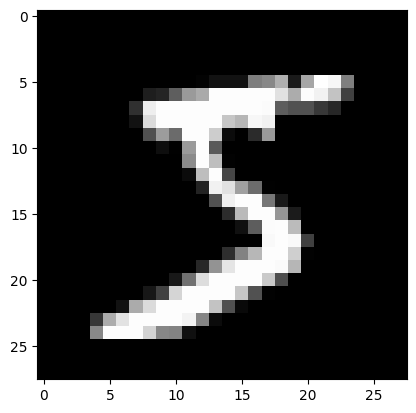

In [13]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## リスト/ディクショナリ入力、またはネストされた入力を使う RNN

ネスト構造の場合、インプルメンターは単一の時間ステップにより多くの情報を含めることができます。たとえば、動画のフレームに、音声と動画の入力を同時に含めることができます。この場合のデータ形状は、次のようになります。

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

別の例では、手書きのデータに、現在のペンの位置を示す座標 x と y のほか、筆圧情報も含めることができます。データは次のように表現できます。

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

次のコードは、このような構造化された入力を受け入れるカスタム RNN セルの構築方法を例に示しています。

### ネストされた入力/出力をサポートするカスタムセルを定義する

独自レイヤーの記述に関する詳細は、「[サブクラス化による新規レイヤーとモデルの作成](https://www.tensorflow.org/guide/keras/custom_layers_and_models/)」を参照してください。

In [14]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}


### ネストされた入力/出力で RNN モデルを構築する

上記で定義した `keras.layers.RNN` レイヤーとカスタムセルを使用する Keras モデルを構築しましょう。

In [15]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

### ランダムに生成されたデータでモデルをトレーニングする

このモデルに適した候補データセットを持ち合わせていないため、ランダムな Numpy データを使って実演することにします。

In [16]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

 1/10 [==>...........................] - ETA: 9s - loss: 1.2608 - rnn_1_loss: 0.3448 - rnn_1_1_loss: 0.9160 - rnn_1_accuracy: 0.0781 - rnn_1_1_accuracy: 0.0398

 4/10 [===========>..................] - ETA: 0s - loss: 0.9173 - rnn_1_loss: 0.3091 - rnn_1_1_loss: 0.6082 - rnn_1_accuracy: 0.1055 - rnn_1_1_accuracy: 0.0363

 7/10 [====================>.........] - ETA: 0s - loss: 0.8252 - rnn_1_loss: 0.2881 - rnn_1_1_loss: 0.5371 - rnn_1_accuracy: 0.1138 - rnn_1_1_accuracy: 0.0346

10/10 [==============================] - ETA: 0s - loss: 0.7515 - rnn_1_loss: 0.2690 - rnn_1_1_loss: 0.4825 - rnn_1_accuracy: 0.1094 - rnn_1_1_accuracy: 0.0330

10/10 [==============================] - 1s 20ms/step - loss: 0.7515 - rnn_1_loss: 0.2690 - rnn_1_1_loss: 0.4825 - rnn_1_accuracy: 0.1094 - rnn_1_1_accuracy: 0.0330


Keras `keras.layers.RNN` レイヤーでは、シーケンス内の個別のステップの数学ロジックを定義することだけが期待されています。シーケンスのイテレーションは、`keras.layers.RNN` レイヤーによって処理されます。新しいタイプの RNN（LSTM など） を素早くプロトタイプ化する上で、非常に強力な方法です。

詳細については、[API ドキュメント](https://https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN/)を参照してください。